In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data
clustered_df = pd.read_csv('data/Cluster_data/Clusters.csv')

# Extract stock names
stock_names = clustered_df.columns[1:]  # Assuming the first column is the date

# Get companies in Cluster 1, dropping any NaN values
cluster_1_companies = clustered_df['Cluster 1'].dropna().tolist()

# Filter the dataset to include only Cluster 1 companies
df_cluster_1 = df[['date'] + [col for col in df.columns if col in cluster_1_companies]]
df_cluster_1.head(11)
# Print the filtered DataFrame
counter=0
for col in df_cluster_1.columns:
    print(col)
    counter+=1
    print(counter)
df_cluster_1.to_csv("data\cluster_1")
#print(df) #every 5th row is a friday
#print(df) #every 5th row is a friday

date
1
ABT
2
ACGL
3
ADM
4
AJG
5
AMP
6
AMT
7
AON
8
APA
9
APTV
10
ARE
11
AXP
12
AZO
13
BA
14
BAC
15
BAX
16
BG
17
BK
18
BKR
19
BLDR
20
BLK
21
BRO
22
BWA
23
BX
24
BXP
25
C
26
CAT
27
CB
28
CBRE
29
CCI
30
CCL
31
CFG
32
CHD
33
CHRW
34
CI
35
CL
36
CMI
37
CMS
38
COF
39
COP
40
CTRA
41
CTVA
42
CVX
43
CZR
44
DAL
45
DAY
46
DECK
47
DFS
48
DOW
49
DRI
50
DVA
51
DVN
52
DXCM
53
ENPH
54
EOG
55
EQT
56
ETR
57
EXR
58
F
59
FCX
60
FE
61
FI
62
FITB
63
FMC
64
FOX
65
FOXA
66
FRT
67
FSLR
68
GD
69
GNRC
70
GPN
71
GS
72
HAL
73
HAS
74
HBAN
75
HES
76
HIG
77
HOLX
78
HSIC
79
HUBB
80
HUM
81
HWM
82
IBM
83
ICE
84
INTU
85
IVZ
86
JBHT
87
JNJ
88
KEY
89
KHC
90
KKR
91
KMB
92
KMI
93
L
94
LLY
95
LOW
96
LW
97
MHK
98
MMC
99
MOS
100
MPC
101
MS
102
MTB
103
NCLH
104
NFLX
105
NTRS
106
NVR
107
OKE
108
ORLY
109
OXY
110
PAYX
111
PEP
112
PFG
113
PG
114
PH
115
PHM
116
PLD
117
PNR
118
PODD
119
POOL
120
PRU
121
PSX
122
PYPL
123
REG
124
REGN
125
ROK
126
ROL
127
ROST
128
RSG
129
SBAC
130
SLB
131
SNA
132
SPG
133
STLD
134
SYF
135
T
136
TDY
137
TE

In [2]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df_cluster_1), 5):
    if i + 4 >= len(df_cluster_1):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df_cluster_1.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df_cluster_1.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.5, 'n_estimators': 150, 'min_child_weight': 9, 'max_depth': 4, 'max_delta_step': 10, 'learning_rate': 0.02, 'lambda': 1, 'gamma': 2, 'alpha': 1}
Best R^2 Score: 0.4198417803396751


In [4]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [5]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.44203935 0.39699284 0.46761217 0.40224058 0.39032395]
Mean CV R^2 Score: 0.4198417803396751
Test R^2 Score: 0.48648817470241956
Baseline R^2 Score: -0.0008254230919890748


In [6]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 1.5080236933270992
Baseline RMSE: 2.1052908593608795
Model Improvement: 0.5972671660337803


In [7]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Daily change standard deviation
daily_changes = np.diff(y_test).std()
print(f"Daily Change Std Dev: {daily_changes:.2f}")

Model RMSE: 1.51
Baseline RMSE: 2.11
Model Improvement: 0.60
Daily Change Std Dev: 2.99


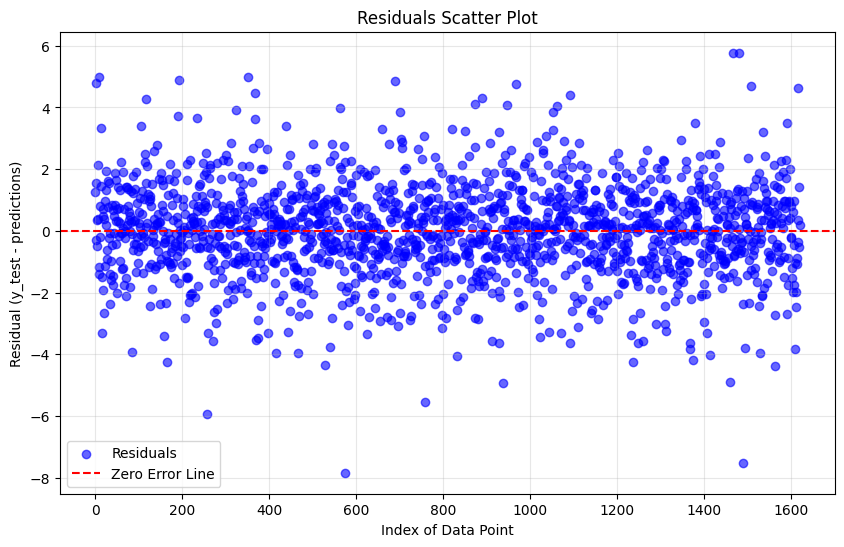

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Residuals (errors for each prediction)
residuals = y_test - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


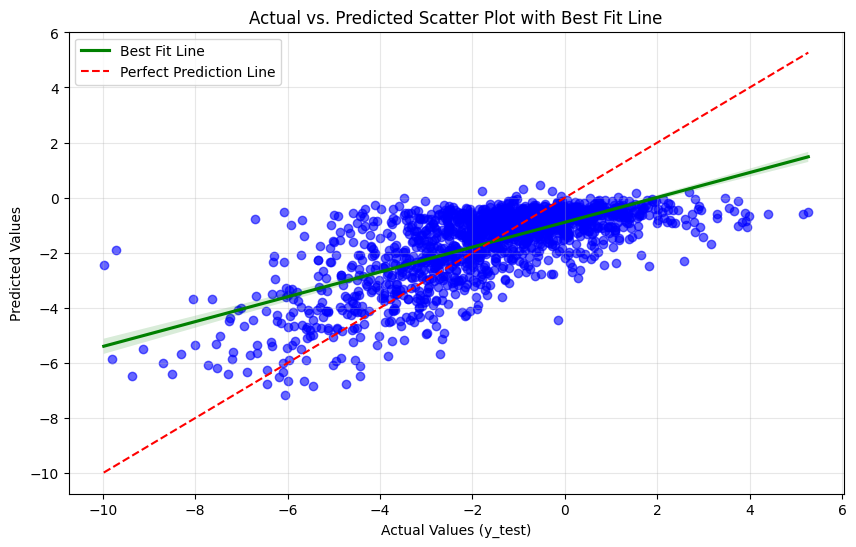

In [9]:
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6, 'label': 'Predicted vs. Actual'}, color='blue', line_kws={'color': 'green', 'label': 'Best Fit Line'})

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot with Best Fit Line')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

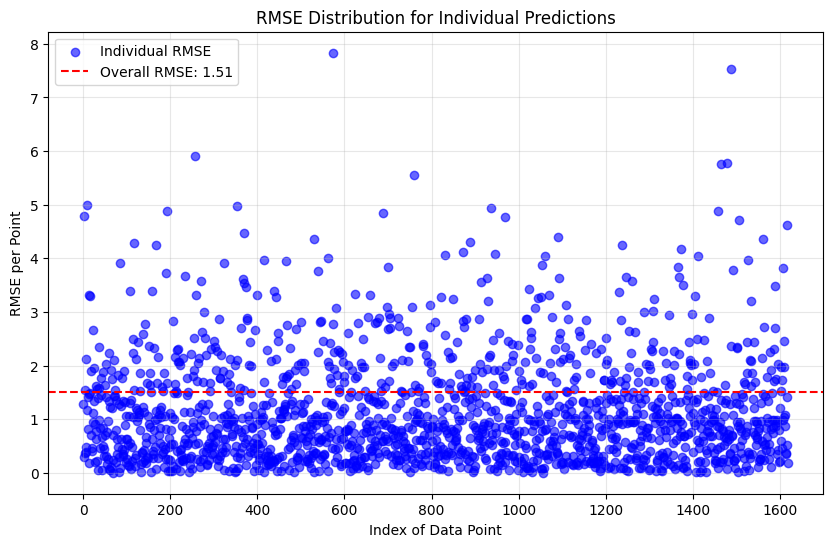

In [10]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
